## KNN回归预测二手车价格
KNN回归预测二手车价格的思路很简单，在历史数据中找到待预测样本的最相近的K个数据，通过这K个历史数据的平均（或加权平均）值得到待预测样本的回归值。

In [1]:
# 导入用到的第三方库
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# 载入数据
filepath_test = './used_car_testA_20200313.csv'
filepath_train = './used_car_train_20200313.csv'
Train_data = pd.read_csv(filepath_train, sep=' ')
Test_data = pd.read_csv(filepath_test, sep=' ')
## 输出数据的大小信息
print('Train data shape:',Train_data.shape)
print('TestA data shape:',Test_data.shape)


Train data shape: (150000, 31)
TestA data shape: (50000, 30)


### 数据探索性分析
1 describe种有每列的统计量，个数count、平均值mean、方差std、最小值min、中位数25% 50% 75% 、以及最大值 看这个信息主要是瞬间掌握数据的大概的范围以及每个值的异常值的判断，比如有的时候会发现999 9999 -1 等值这些其实都是nan的另外一种表达方式

2 info 通过info来了解数据每列的type，有助于了解是否存在除了nan以外的特殊符号异常

3 head 通过head来了解展示前五行的数据


In [3]:
# 通过info,describe或head函数查看数据的基本信息
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4       

In [4]:
Test_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,150000,66932,20111212,222.0,4,5.0,1.0,1.0,313,15.0,...,0.264405,0.121800,0.070899,0.106558,0.078867,-7.050969,-0.854626,4.800151,0.620011,-3.664654
1,150001,174960,19990211,19.0,21,0.0,0.0,0.0,75,12.5,...,0.261745,0.000000,0.096733,0.013705,0.052383,3.679418,-0.729039,-3.796107,-1.541230,-0.757055
2,150002,5356,20090304,82.0,21,0.0,0.0,0.0,109,7.0,...,0.260216,0.112081,0.078082,0.062078,0.050540,-4.926690,1.001106,0.826562,0.138226,0.754033
3,150003,50688,20100405,0.0,0,0.0,0.0,1.0,160,7.0,...,0.260466,0.106727,0.081146,0.075971,0.048268,-4.864637,0.505493,1.870379,0.366038,1.312775
4,150004,161428,19970703,26.0,14,2.0,0.0,0.0,75,15.0,...,0.250999,0.000000,0.077806,0.028600,0.081709,3.616475,-0.673236,-3.197685,-0.025678,-0.101290


In [5]:
Train_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [6]:
## 1) 查看每列的存在nan情况
Train_data.isnull().sum()

SaleID                  0
name                    0
regDate                 0
model                   1
brand                   0
bodyType             4506
fuelType             8680
gearbox              5981
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
price                   0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64

可以发现，缺失值的比率并不多，可以选择舍弃或者补值；类型上面只有notRepairedDamage是object类型其他都为数字,仔细查看，可以发现notRepairedDamage有‘-’这样的值，需要处理

In [7]:
Train_data['notRepairedDamage'].replace('-',-1, inplace=True)
Test_data['notRepairedDamage'].replace('-',-1, inplace=True)

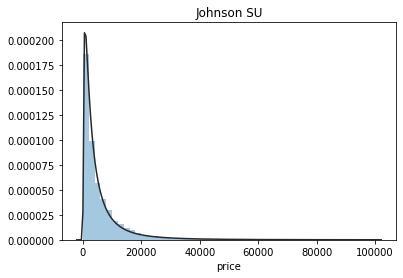

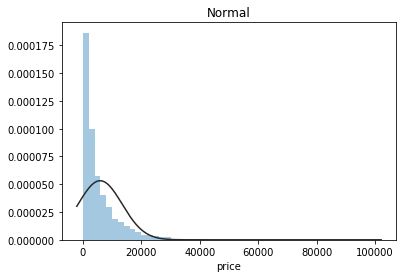

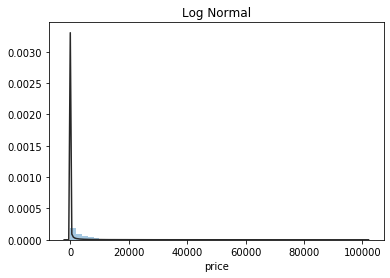

In [8]:
# 了解预测值price的分布情况
## 1) 总体分布概况（无界约翰逊分布等）
import scipy.stats as st
y = Train_data['price']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

Skewness: 3.346487
Kurtosis: 18.995183


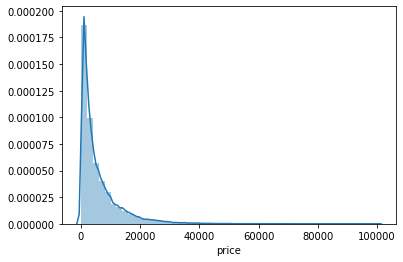

In [9]:
# price是长尾分布，根据不同的算法要求，可以做处理，例如取对数可以使数据分布相对更加符合正态分布
# 对比来看
# 也快看看偏度。峰度
sns.distplot(Train_data['price']);
print("Skewness: %f" % Train_data['price'].skew())
print("Kurtosis: %f" % Train_data['price'].kurt())


Skewness: -0.265100
Kurtosis: -0.171801


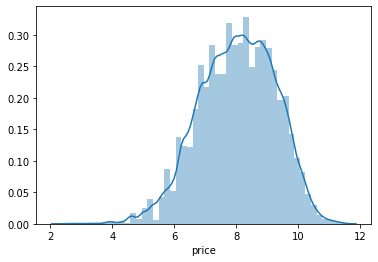

In [10]:
# 取对数
log_price = np.log(Train_data['price'])
sns.distplot(log_price);
print("Skewness: %f" % log_price.skew())
print("Kurtosis: %f" % log_price.kurt())

可以看到取对数后，数据的偏度、峰度都更加靠近正太分布

In [11]:
# 根据业务知识，可以大致区分数值特征与类别特征
numeric_features = ['power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13','v_14' ]

categorical_features = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode'] 
numeric_features.append('price')


In [12]:
## 1) 相关性分析
price_numeric = Train_data[numeric_features]
correlation = price_numeric.corr()
print(correlation['price'].sort_values(ascending = False),'\n')


price        1.000000
v_12         0.692823
v_8          0.685798
v_0          0.628397
power        0.219834
v_5          0.164317
v_2          0.085322
v_6          0.068970
v_1          0.060914
v_14         0.035911
v_13        -0.013993
v_7         -0.053024
v_4         -0.147085
v_9         -0.206205
v_10        -0.246175
v_11        -0.275320
kilometer   -0.440519
v_3         -0.730946
Name: price, dtype: float64 



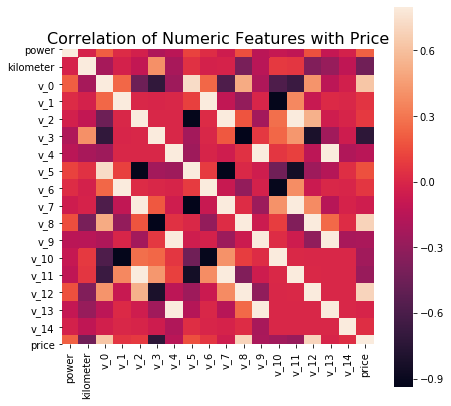

In [13]:
# 可视化来看相关性分布
f , ax = plt.subplots(figsize = (7, 7))

plt.title('Correlation of Numeric Features with Price',y=1,size=16)

sns.heatmap(correlation,square = True,  vmax=0.8)


In [14]:
# 日期的处理
# 日期是比较特殊的特征，往往需要做一些特征工程才能挖掘它带来的效果
def preprocess(df):
    df['notRepairedDamage'].replace('-', -1, inplace=True)
    df['notRepairedDamage'] = df['notRepairedDamage'].astype(float)
    # 提取年月日信息
    df = parse_date(df, 'regDate')
    df = parse_date(df, 'creatDate')
    # 构造特征--计算车龄，以月为单位
    df['carAge'] = (df['creatDate_year'] - df['regDate_year']) * 12 + df['creatDate_month'] - df['regDate_month']
    # 补缺
    # df = df.fillna(-1)
    return df
def parse_date(df, colname):
    newcol = colname + 'timestamp'
    df[newcol] = pd.to_datetime(df[colname].astype('str').apply(date_proc_zero))
    df[colname + '_year'] = df[newcol].dt.year
    df[colname + '_month'] = df[newcol].dt.month
    df[colname + '_day'] = df[newcol].dt.day
    df[colname + '_dayofweek'] = df[newcol].dt.dayofweek
    return df
def date_proc_zero(x):
    m = int(x[4:6])
    if m == 0:
        m = 1
    return x[:4] + '-' + str(m) + '-' + x[6:]


In [15]:
df = preprocess(Train_data)
df = df.dropna()
df.shape

(135884, 42)

In [17]:
# KNN属于惰性模型，基本不需要训练
# 先打乱顺序，然后建模型

# 打乱顺序
df = df.sample(frac=1)

features = ['power', 'kilometer', 'carAge', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9','v_10', 'v_11', 'v_12', 'v_13', 'v_14']
data_feature = df[features]

target = df['price']
data_feature = MinMaxScaler().fit_transform(data_feature)
number = 100000
train_set = data_feature[:number]
train_target = target[:number]
test_set = data_feature[number:]
test_target = target[number:]
# 实例化一个KNN回归模型
KNN = KNeighborsRegressor(n_neighbors=10)
KNN.fit(train_set, train_target)
prediction = KNN.predict(test_set)
print(mean_absolute_error(test_target, prediction))
result = pd.DataFrame()
result['target'] = test_target.values
result['prediction'] = prediction
result.to_csv('./knnresult0504.csv')


862.7386160963104


没有更多的做特征工程和误差分析，粗糙的模型得到的效果一般般